In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader,Subset
from torch.optim import Adam

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CONSTANTS
DATASET_DIR = 'data/'
NUM_CLASSES = 12 # no of classes in the garbage dataset
BATCH_SIZE = 32 # for dataloader
NUM_FOLDS = 10 # for stratified k-fold
LEARNING_RATE = 0.001
NUM_EPOCHS = 1
LOSS_FN = nn.CrossEntropyLoss()

cuda


In [3]:
# Resize images before passing it to the model
transformations = transforms.Compose([transforms.Resize((64, 64)), 
                                      transforms.ToTensor()])
dataset = ImageFolder(DATASET_DIR, transform = transformations)
CLASSES = dataset.class_to_idx.keys()
print('Total dataset',len(dataset))
print('Classes')
display(dataset.class_to_idx)

Total dataset 15515
Classes


{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

Image sampled from class 0 - "battery"
Image sampled from class 4 - "clothes"


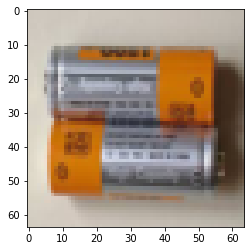

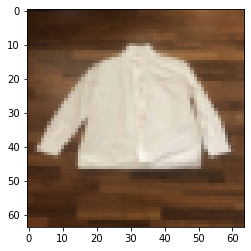

In [4]:
def imshow(image):
    plt.figure()
    plt.imshow(image[0].permute(1, 2, 0))
    print(f'Image sampled from class {image[1]} - "{dataset.classes[image[1]]}"')

imshow(dataset[0])
imshow(dataset[7000])

In [5]:
all_idxs = np.arange(len(dataset))
train_idxs, test_idxs = train_test_split(all_idxs, test_size=0.3,stratify=dataset.targets, random_state=0)
train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]
print('train dataset',len(train_idxs))
print('test dataset',len(test_idxs))

train dataset 10860
test dataset 4655


<BarContainer object of 12 artists>

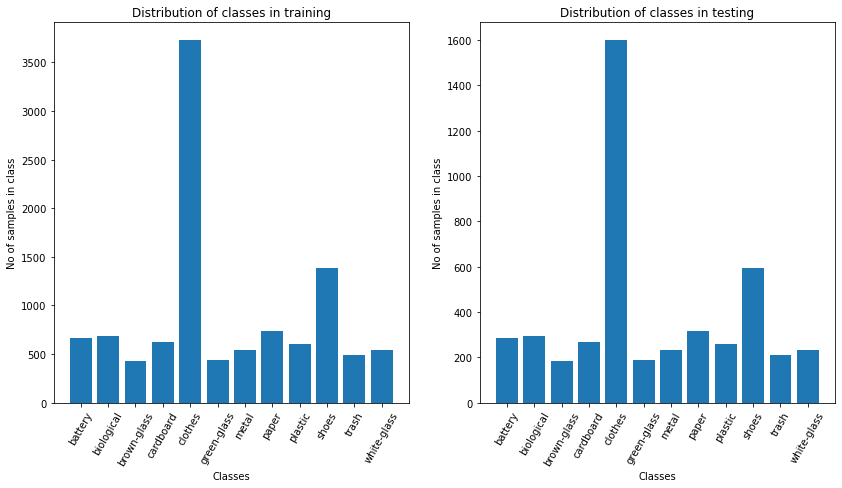

In [6]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())
plt.subplot(1,2,2)
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values())

In [7]:
class GarbageClassifierCNN(nn.Module):
    def __init__(self, kernel_size=5, padding=1):
        super(GarbageClassifierCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=kernel_size, padding=padding),
            nn.Hardtanh(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.Hardtanh(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(14 * 14 * 32, 8*8*8),
            nn.Hardtanh(inplace=True),
            nn.Linear(8*8*8, NUM_CLASSES))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
def evaluate_model(loader):
    model.to('cpu')
    # set model to evaluation mode before evaluation
    model.eval()
    predictions = torch.tensor([])
    targets = torch.tensor([])

    for images, labels in loader:
        out = model(images)
        _, predicted = torch.max(out.data, axis=1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    return conf_matrix,[accuracy, f1, recall, precision]

In [9]:
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

In [10]:
def training_loop(train_loader, optimizer, total_step):
    for epoch in range(NUM_EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, axis=1)
            correct = (predicted == labels).sum().item()
            if i % 10 == 0:
                print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')

    torch.save(model.state_dict(), "./model.pt")

In [11]:
total_scores = []
total_confusion_matrix = np.zeros((NUM_CLASSES,NUM_CLASSES))
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True)

for train_index, test_index in kf.split(train_idxs,train_labels):
    model = GarbageClassifierCNN()
    model.to(device)

    train_fold = Subset(dataset, train_idxs[train_index])
    test_fold = Subset(dataset, train_idxs[test_index])

    train_loader = DataLoader(train_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    total_step = len(train_loader)
    training_loop(train_loader, optimizer, total_step)
    
    conf_matrix, scores = evaluate_model(test_loader)

    total_scores.append(scores)
    total_confusion_matrix = np.add(total_confusion_matrix,conf_matrix)

scores_df = pd.DataFrame(total_scores,columns=['accuracy', 'f1', 'recall', 'precision'])

Epoch [1/1], Step [1/305], Loss: 2.5148, Accuracy: 3.12
Epoch [1/1], Step [11/305], Loss: 1.8373, Accuracy: 50.00
Epoch [1/1], Step [21/305], Loss: 1.8170, Accuracy: 50.00
Epoch [1/1], Step [31/305], Loss: 1.5996, Accuracy: 56.25
Epoch [1/1], Step [41/305], Loss: 1.5162, Accuracy: 50.00
Epoch [1/1], Step [51/305], Loss: 1.2874, Accuracy: 56.25
Epoch [1/1], Step [61/305], Loss: 1.3526, Accuracy: 53.12
Epoch [1/1], Step [71/305], Loss: 1.4333, Accuracy: 43.75
Epoch [1/1], Step [81/305], Loss: 1.4526, Accuracy: 46.88
Epoch [1/1], Step [91/305], Loss: 1.3901, Accuracy: 56.25
Epoch [1/1], Step [101/305], Loss: 1.5501, Accuracy: 46.88
Epoch [1/1], Step [111/305], Loss: 1.0323, Accuracy: 65.62
Epoch [1/1], Step [121/305], Loss: 1.7481, Accuracy: 50.00
Epoch [1/1], Step [131/305], Loss: 1.4754, Accuracy: 50.00
Epoch [1/1], Step [141/305], Loss: 1.5905, Accuracy: 46.88
Epoch [1/1], Step [151/305], Loss: 1.3375, Accuracy: 53.12
Epoch [1/1], Step [161/305], Loss: 1.2519, Accuracy: 62.50
Epoch [1/

KeyboardInterrupt: 

In [ ]:
plot_cm(total_confusion_matrix, CLASSES)
scores_df.mean()

In [15]:
import torchvision.models as models
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to C:\Users\Not A Hero/.cache\torch\hub\v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Not A Hero/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html